# Analysis part - Charizard___Holo_2016_Evolutions

In [1]:
library(ggplot2)
library(quantreg)


df = read.csv('lagged_merged_datasets_final/merged_Charizard___Holo_2016_Evolutions.csv')

#convert prices to returns
grades <- grep("grade[0-9]+price", names(df), value = TRUE)
grade_returns <- sapply(grades, function(x) paste0(x, "_return"))

for(grade in grades) {
  df[paste(grade, "return", sep = "_")] <- c(NA, diff(log(df[[grade]])))
}

#convert adjclosestock and adjclosebond (including their lags) to returns
stock_bond_cols <- grep("adjclose(stock|bond)(lag[0-9]+)?", names(df), value = TRUE)

for(col in stock_bond_cols) {
  df[paste0(col, "_return")] <- c(NA, diff(log(df[[col]])))
}


#convert volume and its lags to 'returns'
volume_cols <- grep("volume(lag[0-9]+)?", names(df), value = TRUE)

for(col in volume_cols) {
  df[paste0(col, "_return")] <- c(NA, diff(log(df[[col]])))  # Adding 1 to avoid log(0) issues
}

#remove rows with NA in the newly created return columns
df <- na.omit(df)

print(head(df))


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'quantreg' was built under R version 3.6.3"Loading required package: SparseM
Warning message:
"package 'SparseM' was built under R version 3.6.3"
Attaching package: 'SparseM'

The following object is masked from 'package:base':

    backsolve



        date grade7price grade8price grade9price grade10price adjclosestock
2 2017-01-01          22    14.00000    50.44444     380.0000       2278.87
3 2017-02-01          22    14.00000    29.90000     390.7117       2363.64
4 2017-03-01          22     9.59000    20.79333     390.7117       2362.72
5 2017-04-01          22    13.48333    24.52571     308.6100       2384.20
6 2017-05-01          22    13.14400    26.52500     308.6100       2411.80
7 2017-06-01          22    16.24625    26.23200     250.2980       2423.41
       volume adjclosebond  stockreturns bondadjusted excessreturns
2 70576420000        3.051  0.0178843582      0.03051    0.02180204
3 69260940000        2.968  0.0371981601      0.02968    0.06440241
4 81664010000        3.018 -0.0003891971      0.03018   -0.01723554
5 65369860000        2.952  0.0090912087      0.02952    0.03095999
6 79719460000        2.857  0.0115762512      0.02857    0.04375775
7 81078810000        2.840  0.0048137752      0.02840    0.0

                         grade7price_return grade8price_return
grade7price_return              1.000000000        0.379543387
grade8price_return              0.379543387        1.000000000
grade9price_return              0.093240034        0.230854171
grade10price_return            -0.018139908       -0.016933567
adjclosestock_return           -0.035289835       -0.040357021
adjclosebond_return             0.146964349       -0.046602330
adjclosestocklag1_return        0.104995369       -0.055863000
adjclosebondlag1_return        -0.030718844        0.036797342
adjclosestocklag2_return       -0.016660974        0.194445777
adjclosebondlag2_return         0.015760460        0.110887383
adjclosestocklag3_return       -0.094706926       -0.095298933
adjclosebondlag3_return        -0.247330807       -0.237699367
adjclosestocklag4_return        0.020985338       -0.022198018
adjclosebondlag4_return        -0.013125711        0.002359587
adjclosestocklag5_return        0.045862657       -0.01

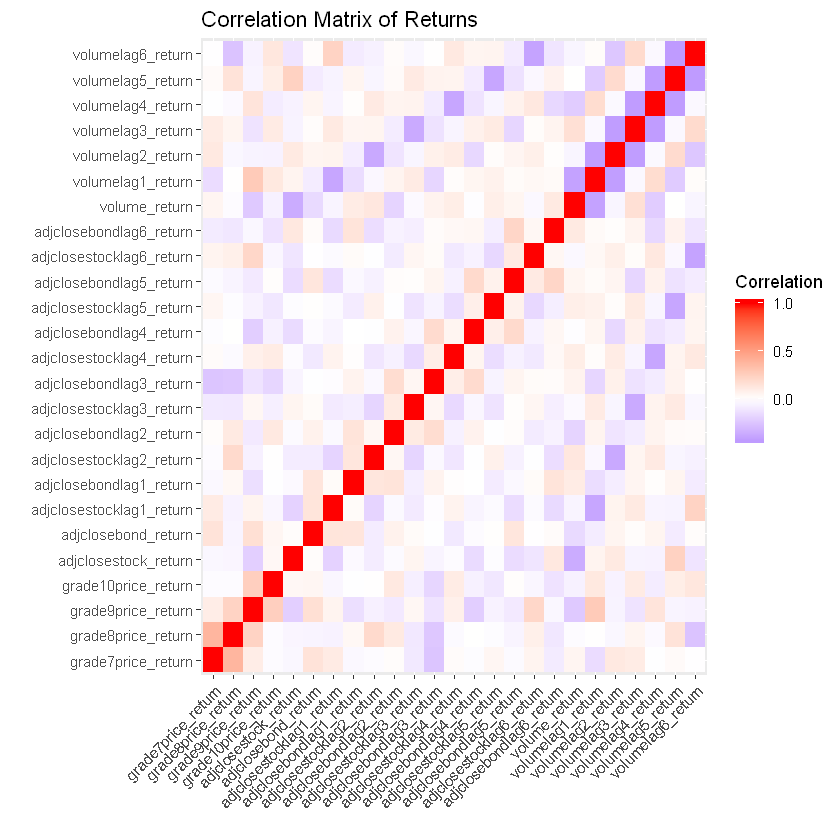

In [15]:
createReturnsCorrelationMatrix <- function(df) {
  # Load necessary libraries
  library(ggplot2)
  library(reshape2)
  
  # Use a simplified pattern to include both "_return" columns and any "volume" columns
  pattern <- "_return"
  selected_columns <- grep(pattern, names(df), value = TRUE)
  
  # Calculate the correlation matrix for the selected columns
  correlation_matrix <- cor(df[, selected_columns], use = "complete.obs")
  
  # Print the correlation matrix to the console
  print(correlation_matrix)
  
  # Melt the correlation matrix for visualization
  melted_correlation_matrix <- melt(correlation_matrix)
  
  # Create the ggplot object for the correlation matrix
  plot <- ggplot(data = melted_correlation_matrix, aes(x=Var1, y=Var2, fill=value)) +
    geom_tile() +
    scale_fill_gradient2(midpoint=0, low="blue", high="red", mid="white") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(x='', y='', title='Correlation Matrix of Returns', fill='Correlation')
  
  # Explicitly print the ggplot object to ensure it's displayed
  print(plot)
  
  # Return the correlation matrix as well
  return(correlation_matrix)
}

# Assuming your adjusted dataset is in 'df'
# Example usage:
correlation_matrix <- createReturnsCorrelationMatrix(df)


## VAR model - try later - if enough time...

## Visualisation

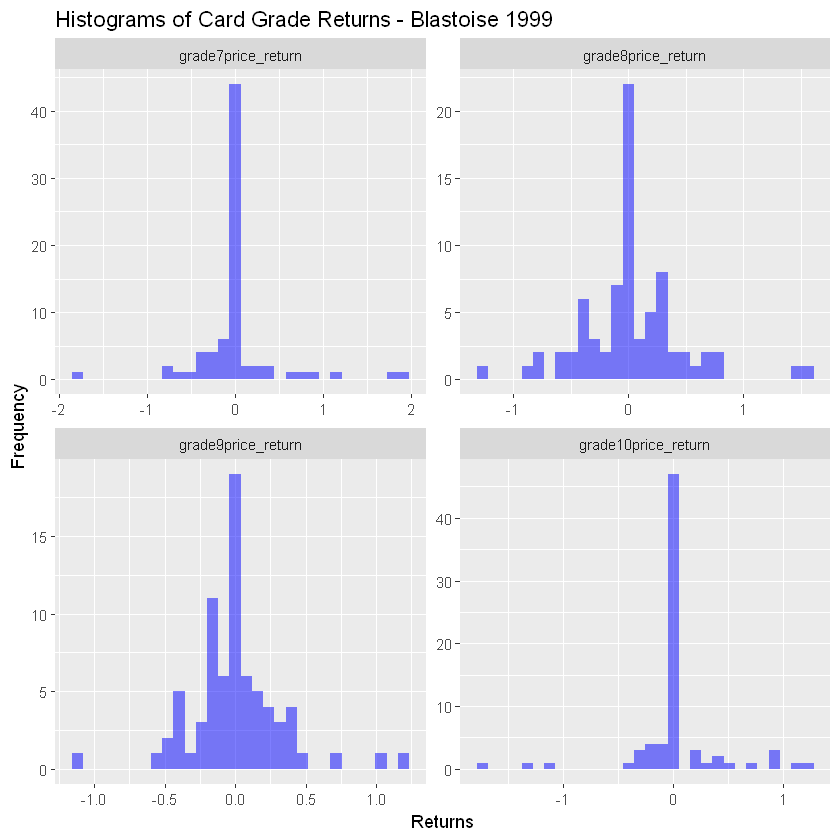

In [4]:

#create a long format data frame suitable for faceting with returns
long_df <- reshape2::melt(df, id.vars = "date", measure.vars = grade_returns)

#histograms for card grade returns
p1 <- ggplot(long_df, aes(x = value)) +
  geom_histogram(bins = 30, fill = "blue", alpha = 0.5) +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Returns", y = "Frequency", title = "Histograms of Card Grade Returns - Blastoise 1999")

print(p1)

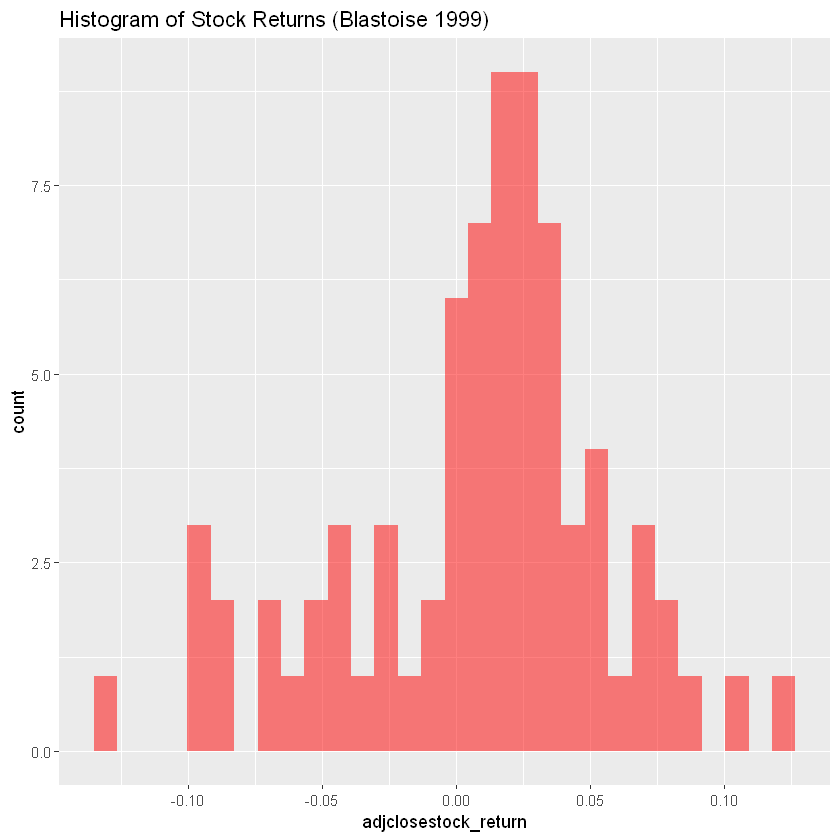

In [5]:
#histogram of stock returns
p2 <- ggplot(df, aes(x = adjclosestock_return)) +
  geom_histogram(bins = 30, fill = "red", alpha = 0.5) +
  labs(title = "Histogram of Stock Returns (Blastoise 1999)")

print(p2)

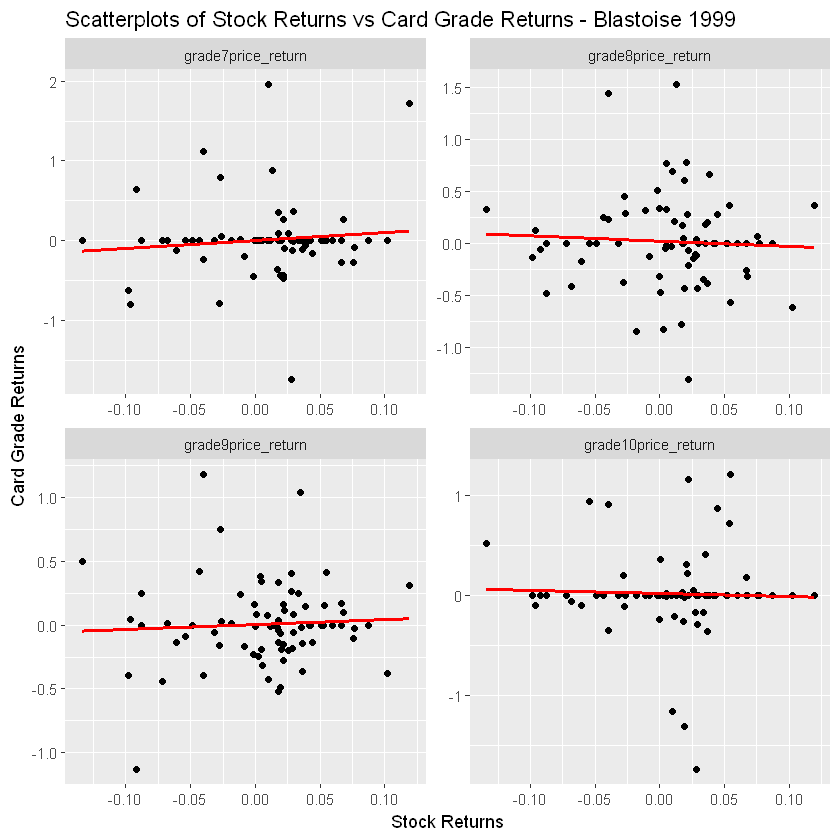

In [6]:
#a long format data frame suitable for scatterplots with returns
long_df <- reshape2::melt(df, id.vars = c("date", "adjclosestocklag1_return"), measure.vars = grade_returns) #ADJUST FOR DIFFERENT LAGS

#scatterplots between stock returns and card grades returns
p3 <- ggplot(long_df, aes(x = adjclosestocklag1_return, y = value)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Stock Returns", y = "Card Grade Returns", title = "Scatterplots of Stock Returns vs Card Grade Returns - Blastoise 1999")

print(p3)

## Choose the variables using AIC

In [11]:

# Load necessary library
library(stats)

# Preparing the initial full model with the dependent variable (choosing one of the grade prices as an example)
# and all potential independent variables (using returns and lagged returns)
# Note: Adjust 'grade5price' to the specific grade price return you are analyzing
full_model <- lm(grade10price_return ~ adjclosestock_return + adjclosebond_return +
                 adjclosestocklag1_return + adjclosebondlag1_return +
                 adjclosestocklag2_return + adjclosebondlag2_return +
                 adjclosestocklag3_return + adjclosebondlag3_return +
                 adjclosestocklag4_return + adjclosebondlag4_return +
                 adjclosestocklag5_return + adjclosebondlag5_return +
                 adjclosestocklag6_return + adjclosebondlag6_return +
                 volume_return + volumelag1_return + volumelag2_return + volumelag3_return + 
                 volumelag4_return + volumelag5_return + volumelag6_return, data = df)

# Perform backward elimination based on AIC
reduced_model <- step(full_model, direction = "backward")

# Display the summary of the reduced model to see the selected variables and their coefficients
summary(reduced_model)


Start:  AIC=-100.76
grade10price_return ~ adjclosestock_return + adjclosebond_return + 
    adjclosestocklag1_return + adjclosebondlag1_return + adjclosestocklag2_return + 
    adjclosebondlag2_return + adjclosestocklag3_return + adjclosebondlag3_return + 
    adjclosestocklag4_return + adjclosebondlag4_return + adjclosestocklag5_return + 
    adjclosebondlag5_return + adjclosestocklag6_return + adjclosebondlag6_return + 
    volume_return + volumelag1_return + volumelag2_return + volumelag3_return + 
    volumelag4_return + volumelag5_return + volumelag6_return

                           Df Sum of Sq    RSS      AIC
- volumelag4_return         1   0.00150 10.886 -102.748
- adjclosestocklag1_return  1   0.00167 10.887 -102.747
- adjclosebondlag1_return   1   0.00392 10.889 -102.731
- adjclosebondlag4_return   1   0.00500 10.890 -102.724
- adjclosestocklag2_return  1   0.01374 10.899 -102.664
- adjclosestocklag4_return  1   0.04350 10.928 -102.459
- adjclosestocklag6_return  1   0.0474


Call:
lm(formula = grade10price_return ~ adjclosebondlag3_return + 
    volumelag5_return + volumelag6_return, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.76448 -0.09963  0.00063  0.07379  1.14950 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)  
(Intercept)              0.02391    0.04823   0.496   0.6216  
adjclosebondlag3_return -0.88068    0.54268  -1.623   0.1091  
volumelag5_return        0.50270    0.33031   1.522   0.1325  
volumelag6_return        0.54273    0.32552   1.667   0.0999 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4162 on 71 degrees of freedom
Multiple R-squared:  0.07635,	Adjusted R-squared:  0.03732 
F-statistic: 1.956 on 3 and 71 DF,  p-value: 0.1284


## Models

### OLS

In [12]:
#OLS
ols_model <- lm(grade10price_return ~ adjclosebondlag3_return + 
    volumelag5_return + volumelag6_return, data = df) 

print(summary(ols_model))

library(car)

# Calculate VIF
vif_result <- vif(ols_model)
print(vif_result)

library(lmtest)

# Perform the Breusch-Pagan test
bp_test <- bptest(ols_model)

# Print the test results
print(bp_test)



Call:
lm(formula = grade10price_return ~ adjclosebondlag3_return + 
    volumelag5_return + volumelag6_return, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.76448 -0.09963  0.00063  0.07379  1.14950 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)  
(Intercept)              0.02391    0.04823   0.496   0.6216  
adjclosebondlag3_return -0.88068    0.54268  -1.623   0.1091  
volumelag5_return        0.50270    0.33031   1.522   0.1325  
volumelag6_return        0.54273    0.32552   1.667   0.0999 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4162 on 71 degrees of freedom
Multiple R-squared:  0.07635,	Adjusted R-squared:  0.03732 
F-statistic: 1.956 on 3 and 71 DF,  p-value: 0.1284



Warning message:
"package 'car' was built under R version 3.6.3"Loading required package: carData


adjclosebondlag3_return       volumelag5_return       volumelag6_return 
               1.004955                1.231088                1.226515 

	studentized Breusch-Pagan test

data:  ols_model
BP = 5.1056, df = 3, p-value = 0.1642



Here not very good model...

### Quantile regression

In [13]:
#Quantile regression
library(quantreg)

quantile_model <- rq(grade10price_return ~ adjclosebondlag3_return + 
    volumelag5_return + volumelag6_return , data = df, tau = seq(from=0.05, to=0.95, by=0.05))  #change tau for different quantiles
                                                                                                                                   

#print summary of quantile regression models
for(grade_return in grade_returns) {
  #print(paste("Summary of quantile regression model for:", grade_return))
  #print(summary(quantile_models[[grade_return]]))
}

#uncomment the last two commented rows (in the previous loop) if you want to see the results for quantiles from 0.05 to 0.95, by 0.05 step




#### Results for different quantiles of the grade 10 prices x OLS estimates (red line) 

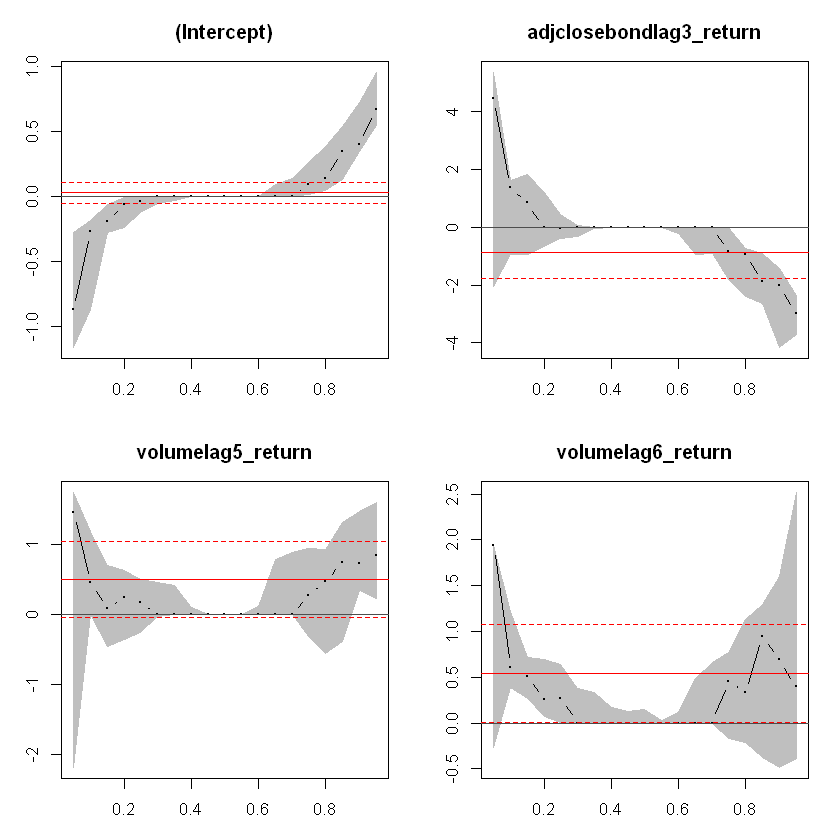

In [14]:

plot(summary(quantile_model))
